<a href="https://colab.research.google.com/github/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/blob/main/AAAI_2023_FIGURE_4_ABD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A function for loading students dataset

In [3]:
from os import listdir
from os.path import isfile, join, isdir
import networkx as nx
import sys
import logging
import pandas as pd
import random
import csv
import requests
!pip3 install wget
import wget
import numpy as np
import os 

def satisfied_thresh( values, person_id, resource_const, person_pref, relevant_attributes ):

    #print(values[person_id])
    
    for item1 in person_pref:
        if item1 not in relevant_attributes:
          continue          
        try:
            pp1 = person_pref[item1]
            rc1 = resource_const[item1]

            v1 = values[person_id][(item1,pp1)]
            v2 = values[person_id][(item1,rc1 )]
            if  v1>v2 :
                return False
        except Exception as e:
            print(resource_const[item1])
            raise e
    return True

def load(reg_min, relevant_attributes, resources_percent,agents_percent, rho=-1):

    courses = wget.download('https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/main/data/Course-Classroom-Dataset/courses.csv', 'courses.csv')
    rooms = wget.download('https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/main/data/Course-Classroom-Dataset/rooms.csv','rooms.csv')
    order_of_regions = wget.download('https://raw.githubusercontent.com/yohayt/Resource-Sharing-Through-Multi-Round-Matchings/main/data/Course-Classroom-Dataset/order_of_regions.csv', 'order_of_regions.csv')
 
    disability = {}
    course = {}
    room = {}
    all_regions = set()

    with open(courses, "r") as f_courses,\
            open(rooms,"r") as f_rooms:

                first = True
                reader =  csv.reader(f_courses, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True)
                for c in reader:
                    sp = c
                    if first:
                        first = False
                        continue
                    try:
                        course[sp[0]] = { 'course_id': sp[1], 'planned_registered_students':int(sp[2]),'prefered_region':int(sp[3])}
                    except Exception as e:
                        print("ERROR IN LINE {}".format(sp))
                        raise e
                    
                first = True
                reader =  csv.reader(f_rooms, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True)
                for r in reader:    
                        if random.random()>0.1:
#                        if True:

                            sp = r
                            if first:
                                first = False
                                continue
                            try:
                                room[sp[0]] = { 'region':int(sp[1]),'building':int(sp[2]),'room':int(sp[3]),'capacity':int(sp[4]), 'accessories':sp[5].split(",") if sp[5] != 'NULL' else [] }
                                all_regions.add(int(sp[1]))                               
                            except Exception as e:
                                print("ERROR IN LINE {}".format(sp))
                                raise e
                        else:
                            try:
                                sp = r
                                all_regions.add(int(sp[1]))
                            except:
                                continue
    edges = []

    #print("Total nodes l {} nodesr {}".format(len(course), len(room)))

    dropped_region = 0
    dropped_disability = 0
    dropped_capacity = 0
    retain_region = 0    
    
    resource_attr = {}
    pref_attr = {}
    
    
    all_disabilities = ['hearing_dis_sys', 'accecible_table']

    for c in course:
       
        cap = course[c]['planned_registered_students']

        if cap == 0:
            continue
       
        if c not in pref_attr:
                pref_attr[c] = {}

        pref_attr[c]['hearing'] = 0
        pref_attr[c]['table'] = 0

        cap = course[c]['planned_registered_students']

        if c not in pref_attr:
            pref_attr[c] = {}

        pref_attr[c]['capacity_min'] = int(cap / 10)*10
        pref_attr[c]['capacity_max'] = min(int(int((4/3 * cap) / 10)*10), 270)

        pref_attr[c]['region'] = course[c]['prefered_region']
        if pref_attr[c]['region'] <0:
            pref_attr[c]['region'] = 2000

    for r in room:
        if random.random()>=resources_percent:
          continue

        cap = room[r]['capacity']
        if (1000000 + int(r)) not in resource_attr:
                resource_attr[1000000 + int(r)] = {}

        resource_attr[1000000 + int(r)]['capacity_min'] = int(cap / 10 )*10
        resource_attr[1000000 + int(r)]['capacity_max'] = int(cap / 10 )*10
        resource_attr[1000000 + int(r)]['region'] = room[r]['region']
        resource_attr[1000000 + int(r)]['hearing'] = 1 if 'hearing_dis_sys' in room[r]['accessories'] else 0
        resource_attr[1000000 + int(r)]['table'] = 1 if 'accecible_table' in room[r]['accessories'] else 0

    G = nx.Graph()
    for edge in edges:
        first_node = edge[0]
        last_node = edge[1]
        G.add_node(first_node, bipartite=0)
        G.add_node(last_node, bipartite=1)           
        G.add_edge( first_node, last_node)

    for c in pref_attr:
        G.add_node(c, bipartite=0)

    for r in resource_attr:
        G.add_node(r, bipartite=1)

    n_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
    n = len(n_nodes)
    m = len(set(G) - n_nodes)

    values = {}

    regions_set = set()
    for resource in resource_attr:
        regions_set.add(resource_attr[resource]['region'])
   
    for c in pref_attr:
        if pref_attr[c]['region'] == 2000:
            pref_attr[c]['region']= random.choice(list(regions_set))

    regions_order = {}
    with open(order_of_regions, "r") as f:
        for line in f:
            sp = line.strip().split(":")
            regions_order[int(sp[0])] = []
            for item in sp[1].strip().split(","):
                regions_order[int(sp[0])].append(int(item))

    for c in course:
        if c not in pref_attr:
            continue

        values[c]={}

        i=0
        for i in range(0,280, 10):
            values[c][('capacity_min',i)]= i/10
        j=0    
        for i in range(270, -1, -10):
            values[c][('capacity_max',i)]= j
            j+=1

        if pref_attr[c]['region'] in regions_order:
            res_order = list( regions_order[ pref_attr[c]['region'] ])
        else:
            regions_set = all_regions
            res_order = list(regions_set)    
            random.shuffle(res_order)

        ln = len(res_order)-1
        
        for i,v in enumerate(res_order):  #limit values for having more assignments
            values[c][('region',v)] = min(max(0, ln - i), reg_min)

        values[c][('hearing', 0 )] = 0 
        values[c][('hearing', 1 )] = 1
        values[c][('table', 0 )] = 0
        values[c][('table', 1 )] = 1

    top = [n for n,d in G.nodes(data=True) if d['bipartite'] == 0]
    req5 = {}
    req6 = {}
    k1=5
    k2 = 6

    for agent in top:
        if rho > 0:
          need = rho
        else:
          need = random.randint(1, 3)

        places1 = random.sample(range(k1), need)
        places2 = random.sample(range(k2), need)

        for i in range(k1):
            if i in places1:
                continue
            else:
                if random.random()>0.5:
                    places1.append( i )

        for i in range(k2):
            if i in places2:
                continue
            else:
                if random.random()>0.5:
                    places2.append( i )

        truth_list = []
        for item in range(k1):
            if item in places1:
                truth_list.append(True)
            else:
                truth_list.append(False)

        req5[agent] = (need, truth_list)

        truth_list = []
        for item in range(k2):
            if item in places2:
                truth_list.append(True)
            else:
                truth_list.append(False)

        req6[agent] = (need, truth_list)
        
        n_nodes = sorted(list({n for n, d in G.nodes(data=True) if d["bipartite"] == 0}))
        resources = sorted(list(resource_attr.keys()))
       
        for node in n_nodes:
            for i in resources:
              
              if satisfied_thresh(values, node, resource_attr[i], pref_attr[node], relevant_attributes):
                G.add_edge(node, i)

    degs = []
    for agent in n_nodes:
      degs.append((agent, G.degree(agent)))
      if random.random()>=agents_percent or G.degree(agent) == 0:
        G.remove_node(agent)

    return G,n,m, resource_attr, pref_attr, values, req5, req6

def get_delta1(G,days):
  delta = {}
  k = len(next(iter(days.values()))[1])
  values = set()
  for i in range(k+1):
    for j in range(k+1):
      if i<=j and j>0:
        values.add(i/j)
  ls = sorted(list(values), key=lambda x: -x)
  ord = {}
  for c,item in enumerate(ls):
    ord[item] = c
  xi = {}
  for item in ls:
    xi[item] = (k*n)**ord[item]
    #print(xi[item])
  mx = max(xi.values())
  agents = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  for agent in agents:
    rho = days[agent][0]
    delta[agent] = {}
    for i in range(1, rho+1):
        delta[agent][i]=xi[(i-1)/rho]
 # print("mn mx " , min(xi.values()),max(xi.values()))
  return delta, max(xi.values())

def get_delta2(G,days):
  delta = {}
  k = len(next(iter(days.values()))[1])
  agents = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  for agent in agents:
    rho = days[agent][0]
    delta[agent] = {}
    for i in range(1, rho+1):
        delta[agent][i]=1
 # print(delta)
  return delta,1

def run_for_parameters(G, n, m, days, delta = 2):
  
  k = len(next(iter(days.values()))[1])
  agents =    {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
  resources = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
  
  for i,agent in enumerate(agents):
    G.nodes[agent]['rho'] = days[agent][0]

  #generate the auxilary graph
  G_construction = nx.Graph()
  #for each resource in original graph, add k resources, one per matching round
  for resource in resources:
    for i in range(1,k+1):
      res = str(resource) +"_" + str(i)
      G_construction.add_node(res, bipartitie=1)
  kis = {}

  #for each agent in original graph, add k agents in auxilary
  for agent in agents:
    relevant_days = days[agent][1]
    ki = 0
    for i in range(1,k+1):
      if not relevant_days[i-1]:
        continue
      ki += 1
      ag = str(agent) +"-" + str(i)
      G_construction.add_node(ag, bipartitie=0)
    kis[agent] = ki
    rho = G.nodes[agent]['rho']
    #add type 2 dummy resources, with total of rho.
    for j in range( 1, rho+1 ):
      ag = "x-" + str(agent) +"_"+str(j)
      G_construction.add_node(j,bipartite=1)

    #add type 3 dummy resources, one per unmatched round of an agent
    for j in range( 1, ki-rho+1 ):
      ag = "z-" + str(agent) +"_"+str(j)
      G_construction.add_node(j,bipartite=1)

  verbose = False
  el = []

# print("total edges are ", len(el))
  #add edges to type 3 dummy resources
  bign = k+1
  if delta==1:
    delta, mx = get_delta1(G,days)
  elif delta==2:
    delta,mx = get_delta2(G,days)

  #print(mx)
  #add edges of original graph to auxilary
  for agent in agents:
    if agent == 2:
      verbose = True
    for resource in resources:
      if (agent,resource) not in G.edges() and (resource,agent) not in G.edges():
        continue
      relevant_days = days[agent][1]
      for i in range(1,k+1):
          if relevant_days[i-1]:
            edge = (str(agent) +"-" + str(i),  str(resource) +"_" + str(i))
            if verbose:
              el.append(edge)
            G_construction.add_edge(edge[0], edge[1], weight=mx)
    verbose = False

  for agent in agents:
    relevant_days = days[agent][1]
    for i in range(1,k+1):
      if relevant_days[i-1]:
        rho = G.nodes[agent]['rho']
        for j in range( 1, rho+1 ):
          ag = "x-" + str(agent) +"_"+str(j)
          try:
            G_construction.add_edge(str(agent) +"-" + str(i), ag,weight=(mx-delta[agent][j]))
          except Exception as e:
            print("Exception")
            print("GOT AN EXCEPTION WHEN ADDING EDGE", rho, j, delta[agent])

        for j in range( 1, kis[agent]-rho+1 ):
          ag = "z-" + str(agent) +"_"+str(j)
          G_construction.add_edge(str(agent) +"-" + str(i), ag,weight=bign*mx)
          

  #calculate weighted matching
  matching = nx.max_weight_matching(G_construction, weight='weight')
  #print(matching)

  #Given the resulting matching, construct k matchings in original graph
  ret = []
  for l in range(k):
        ret.append(set())

  agent_assignments = {}

  #print(matching)
  for (x,y) in matching:
      if "z-" in y or 'z-' in x or "x-" in y or 'x-' in x:
        continue
      else:
        if '-' in x: #sign for an agent
          agent = x
          resource = y
        else:
          agent = y
          resource = x
        place = int(agent.split('-')[1]) - 1
        ag = agent.split('-')[0]
        ret[place].add((ag,resource.split("_")[0]))

  return agents, resources, G, ret



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Given the students dataset and graph run the max total algorithm

A wrapper for showing the graphs

A:

courses.csv
courses (1).csv
courses (2).csv
courses (3).csv
courses (4).csv
courses (5).csv
courses (6).csv
courses (7).csv
courses (8).csv
courses (9).csv
courses (10).csv
courses (11).csv
courses (12).csv
courses (13).csv
courses (14).csv
courses (15).csv
courses (16).csv
courses (17).csv
courses (18).csv
courses (19).csv
courses (20).csv
courses (21).csv
courses (22).csv
courses (23).csv
courses (24).csv
courses (25).csv
courses (26).csv
courses (27).csv
courses (28).csv
courses (29).csv
courses (30).csv
courses (31).csv
courses (32).csv
courses (33).csv
courses (34).csv
courses (35).csv
courses (36).csv
courses (37).csv
courses (38).csv
courses (39).csv
courses (40).csv
courses (41).csv
courses (42).csv
courses (43).csv
courses (44).csv
courses (45).csv
courses (46).csv
courses (47).csv
courses (48).csv
courses (49).csv


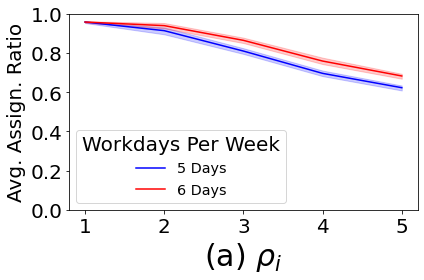

In [4]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns

ret1 = []
ret2 = []

a = { 'hearing','table','capacity_min','capacity_max', 'region' }

for l in range(10):
  for rho in {1,2,3,4,5}:
        G,n,m, resource_attr, pref_attr, values, req5, req6 = load(6, a, 1.0,1.1, rho )
        agents5, resources5, G5, ret5 = run_for_parameters(G, n, m, req5)
        agents6, resources6, G6, ret6 = run_for_parameters(G, n, m, req6)

        total5 = 0
        total6 = 0

        for agent in req5:
                total5 += req5[agent][0]
        for agent in req6:
                total6 += req6[agent][0]
        v1 = 0
        for x in ret5:
          v1 += len(x)
        v1 /= total5

        v2 = 0
        for x in ret6:
          v2 += len(x)
        v2 /= total6
        
        ret1.append((rho,v1))
        ret2.append((rho,v2))

df1 = pd.DataFrame(ret1, columns =['rho',  'avg'])
df2 = pd.DataFrame(ret2, columns =['rho',  'avg'])

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1 = sns.lineplot(x='rho', y='avg', data=df1, color='blue', label="5 Days", linestyle="solid")
ax2 = sns.lineplot(x='rho', y='avg', data=df2, color='red', label="6 Days", linestyle="solid")

rho_p =r"$\rho_i$"
ax.set_xlabel("(a) " + rho_p, fontsize = 30)
ax.set_ylabel("Avg. Assign. Ratio", fontsize = 20)

ax.legend(title= "Workdays Per Week", fontsize='x-large', title_fontsize='20')

plt.xticks(fontsize=20 )
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20 )

import os

path = "/content/gdrive/My Drive/courses_results"
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)

plt.tight_layout()
plt.show()
#plt.savefig(join(path,"ClsRho.pdf"), format="pdf")



B:

courses (50).csv
courses (51).csv
courses (52).csv
courses (53).csv
courses (54).csv
courses (55).csv
courses (56).csv
courses (57).csv
courses (58).csv
courses (59).csv


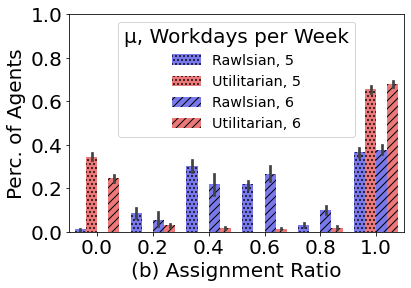

In [5]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
import numpy as np

retp1 = []
retp2 = []

a = { 'hearing','table','capacity_min','capacity_max', 'region' }
rho = 5

ratios1 = []
ratios2 = []
yall = []

for l in range(10):  
      y=[]
      G,n,m, resource_attr, pref_attr, values, req5, req6 = load(6, a, 1.0,1.1,rho )
      agents52, resources52, G52, ret51 = run_for_parameters(G, n, m, req5,delta=1)
      agents52, resources52, G52, ret52 = run_for_parameters(G, n, m, req5,delta=2)
      agents62, resources62, G62, ret61 = run_for_parameters(G, n, m, req6,delta=1)
      agents62, resources62, G62, ret62 = run_for_parameters(G, n, m, req6,delta=2)

      agents = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
      
      times_per_agent = {}
      for lst in ret51:
        for pair in lst:
          if pair[0] not in times_per_agent:
            times_per_agent[pair[0]] = 1
          else:
            times_per_agent[pair[0]] += 1

      sum = 0
      num = 0
      for agent in times_per_agent:
        sum += times_per_agent[agent] 
        num +=1

      for agent in agents:
        if agent not in times_per_agent:
          times_per_agent[agent]=0

      for agent in times_per_agent:
          ratio = times_per_agent[agent]/rho
          y.append(('Rawlsian',5,l,rho,ratio,sum))

      times_per_agent = {}
      for lst in ret52:
        for pair in lst:
          if pair[0] not in times_per_agent:
            times_per_agent[pair[0]] = 1
          else:
            times_per_agent[pair[0]] += 1

      for agent in agents:
        if agent not in times_per_agent:
          times_per_agent[agent]=0
      
      for agent in times_per_agent:
          ratio = times_per_agent[agent]/rho
          y.append(('Utilitarian',5,l,rho,ratio,sum))


      times_per_agent = {}
      for lst in ret61:
        for pair in lst:
          if pair[0] not in times_per_agent:
            times_per_agent[pair[0]] = 1
          else:
            times_per_agent[pair[0]] += 1

      sum = 0
      num = 0
      for agent in times_per_agent:
        sum += times_per_agent[agent] 
        num +=1

      for agent in agents:
        if agent not in times_per_agent:
          times_per_agent[agent]=0

      for agent in times_per_agent:
          ratio = times_per_agent[agent]/rho
          y.append(('Rawlsian',6,l,rho,ratio,sum))

      times_per_agent = {}
      for lst in ret62:
        for pair in lst:
          if pair[0] not in times_per_agent:
            times_per_agent[pair[0]] = 1
          else:
            times_per_agent[pair[0]] += 1

      for agent in agents:
        if agent not in times_per_agent:
          times_per_agent[agent]=0
      
      for agent in times_per_agent:
          ratio = times_per_agent[agent]/rho
          y.append(('Utilitarian',6,l,rho,ratio,sum))

      yp1 = {}
      yp2 = {}
      
      for item in y:
        if item[1] == 5:
          if item[0] not in yp1:
            yp1[item[0]] = {}
          if item[4] not in yp1[item[0]]:
            yp1[item[0]][item[4]] = 1
          else:
            yp1[item[0]][item[4]] += 1
        elif item[1] == 6:
          if item[0] not in yp2:
            yp2[item[0]] = {}
          if item[4] not in yp2[item[0]]:
            yp2[item[0]][item[4]] = 1
          else:
            yp2[item[0]][item[4]] += 1

      for item in yp1:
        for item2 in yp1[item]:
          yall.append((item,5,l, item2, yp1[item][item2]/len(agents)))
      for item in yp2:
        for item2 in yp2[item]:
          yall.append((item,6,l, item2, yp2[item][item2]/len(agents)))
df = pd.DataFrame(yall, columns =['Delta', 'Days', 'Experiment', 'Ratio', 'Num'])

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

hue = df['Delta'].astype(str) + ', ' + df['Days'].astype(str)
ax = sns.barplot( x="Ratio", y="Num", hue=hue, data=df, palette=["blue","red"], alpha=.6)

ax.set_xlabel("(b) Assignment Ratio", fontsize=20)
ax.set_ylabel("Perc. of Agents",fontsize=20)
ax.get_legend().remove()

import itertools
hatches = itertools.cycle(['...', '...', '///', '///'])

for i, bar in enumerate(ax.patches):
    if i % 6 == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_xticklabels(ax.get_xticklabels())

plt.legend(title="μ, Workdays per Week", fontsize='x-large', title_fontsize='20')
plt.xticks(fontsize=20 )

plt.yticks([0.0, 0.2,0.4,0.6,0.8,1.0],fontsize=20 )
#plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0],labels=['','','','','',''],fontsize=20 )
import os

isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)
plt.show()

#plt.savefig(join(path,"ClsRatioBar3.pdf"), format="pdf",bbox_inches='tight')


D:

courses (60).csv
courses (61).csv
courses (62).csv
courses (63).csv
courses (64).csv
courses (65).csv
courses (66).csv
courses (67).csv
courses (68).csv
courses (69).csv
courses (70).csv
courses (71).csv
courses (72).csv
courses (73).csv
courses (74).csv
courses (75).csv
courses (76).csv
courses (77).csv
courses (78).csv
courses (79).csv
courses (80).csv
courses (81).csv
courses (82).csv
courses (83).csv
courses (84).csv
courses (85).csv
courses (86).csv
courses (87).csv
courses (88).csv
courses (89).csv


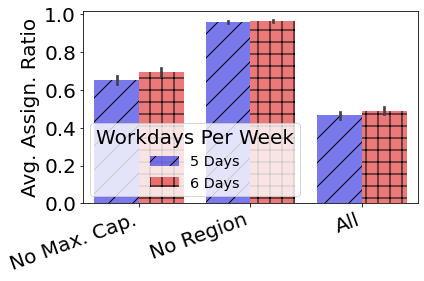

In [6]:
import networkx as nx
from random import choices
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns

relevant_attributes = []
relevant_attributes.append({ 'hearing','table','capacity_min','region' })
relevant_attributes.append({ 'hearing','table','capacity_min','capacity_max' })
relevant_attributes.append({ 'hearing','table','capacity_min','capacity_max', 'region' })
ret = []
for l in range(10):
  for a in relevant_attributes:
        G,n,m, resource_attr, pref_attr, values, req5, req6 = load(8, a,1.0,1.1)
        agents5, resources5, G5, ret5 = run_for_parameters(G, n, m, req5)
        agents6, resources6, G6, ret6 = run_for_parameters(G, n, m, req6)

        total5 = 0
        total6 = 0

        for agent in req5:
                total5 += req5[agent][0]
        for agent in req6:
                total6 += req6[agent][0]
        v1 = 0
        for item in ret5:
          v1+= len(item)
        v1 /= total5
        v2 = 0
        for item in ret6:
          v2+= len(item)
        v2 /= total6

        if a == { 'hearing','table','capacity_min','region' }:
          al = "No Max. Cap."
        elif  a == { 'hearing','table','capacity_min','capacity_max' }:
          al = "No Region"
        else:
          al = "All"
        ret.append((al,"5 Days",v1))
        ret.append((al,"6 Days",v2))

df = pd.DataFrame(ret, columns =['type', 'days', 'avg'])
ax = sns.barplot( x="type", y="avg", hue="days", data=df, palette=["blue","red","white"], alpha=.6)

ax.set_ylabel("Avg. Assign. Ratio",fontsize=20)
ax.set_xlabel("",fontsize=20)
ax.get_legend().remove()

import itertools
hatches = itertools.cycle(['/', '+'])
for i, bar in enumerate(ax.patches):
    if i % 3 == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

plt.legend(title="Workdays Per Week", fontsize='x-large', title_fontsize='20')
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )

import os

path = "/content/gdrive/My Drive/courses_results"
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)

plt.tight_layout()
plt.savefig(join(path,"ClsBar.pdf"), format="pdf", bbox_inches='tight')

